# Computational Physics - Exercise 2 (part 2/2)

In this section, we vary the value of $\nu$ from $ 0.01 \rm{fm^{-2}} $ to $ 0.49 \rm{fm^{-2}} $ in steps of $ 0.01 \rm{fm^{-2}} $ and with a fixed value of radial wave functions (30), in order to find the best value of $\nu$. It turns out to be $ 0.11 \pm 0.01 \rm{fm^{-2}} $. This result is in agreement with the expected value of $\nu = 0.11 \pm 0.01 \rm{fm^{-2}} $, obtained in the initial discussion. The only difference with respect to the previous code consists of adding the parameter $\nu$ as a variable to all those functions which depend on it.

In [1]:
# Importiamo le librerie necessarie

import numpy as np
from scipy.integrate import quad
import scipy.constants as sp
import math
from scipy.linalg import eigh
from pylab import xlabel,ylabel
import matplotlib.pyplot as plt
from scipy import special

In [2]:
# Dati iniziali

hc = sp.hbar*sp.c*10**(28)/1.6022 # h*c tagliato in MeV*fm
m_protone = 938.27; # in MeV/c^2
m_neutrone = 939.57; # in MeV/c^2
mu = m_protone * m_neutrone / (m_protone + m_neutrone)
prefactor = hc**2 / (2*mu)
M = 30 # number of radial wave functions


In [3]:
# Polinomi di Hermite

def He(x,n):
    h0=1
    if(n==0):
        return h0
    h1=2*x
    if(n==1):
        return h1
    if(n>1):
        for i in range(2,n+1):
            h2=2*x*h1-2*(i-1)*h0
            h0=h1
            h1=h2
        return h2

In [4]:
# Fattore di normalizzazione

def N(n,nu):
    N_quadro = np.sqrt(2*nu/sp.pi) / (4**(n) * math.factorial(2*n+1))
    N = np.sqrt(N_quadro)
    return N

In [5]:
# Funzioni d'onda radiali

def R(r,n,nu):
    x = np.sqrt(2*nu) * r
    R = N(n,nu) * np.exp(- nu * r**2) * He(x,2*n+1) / r
    return R

In [6]:
# Derivate dei polinomi di Hermite

def dHe(x,n):
    if(n==0):
        return 0
    else:
        H_prime = 2*n*He(x,n-1)
        return H_prime

def d2He(x,n):
    if(n==0 or n==1):
        return 0
    else:
        H_second = 4*n*(n-1)*He(x,n-2)
        return H_second

In [7]:
# Elementi di matrice dell'energia cinetica

def kinetic_element(m,n,nu):
    if (m == n-1):
        risultato1 = (- prefactor) * nu * np.sqrt((2*m+2)*(2*m+3))
        return risultato1
    elif (m == n):
        risultato2 = (+ prefactor) * nu * (4*m+3)
        return risultato2
    elif (m == n+1):
        risultato3 = (- prefactor) * nu * np.sqrt(2*m*(2*m+1))
        return risultato3
    else:
        return 0

In [8]:
# Elementi di matrice dei termini nel potenziale

def elementR(m,n,nu):
    v0R = 200 # in MeV
    kR = 1.487 # in fm^{-2}
    roots, pesi = special.roots_hermite(2*M+2)
    froots = (v0R/np.sqrt(2*nu+kR))*N(m,nu) * He(roots*np.sqrt(2*nu) / np.sqrt(2*nu+kR), 2*m+1)*N(n,nu)*He(roots*np.sqrt(2*nu) / np.sqrt(2*nu+kR),2*n+1)
    risultato = np.dot(froots,pesi)/2
    return risultato 

def elementS(m,n,nu):
    v0S = 91.85 # in MeV
    kS = 0.465 # in fm^{-2}
    roots, pesi = special.roots_hermite(2*M+2)
    froots = (-v0S/np.sqrt(2*nu+kS))*N(m,nu) * He(roots*np.sqrt(2*nu) / np.sqrt(2*nu+kS), 2*m+1)*N(n,nu)*He(roots*np.sqrt(2*nu) / np.sqrt(2*nu+kS),2*n+1)
    risultato = np.dot(froots,pesi)/2
    return risultato

def elementT(m,n,nu):
    v0T = 178 # in MeV
    kT = 0.639 # in fm^{-2}
    roots, pesi = special.roots_hermite(2*M+2)
    froots = (-v0T/np.sqrt(2*nu+kT))*N(m,nu) * He(roots*np.sqrt(2*nu) / np.sqrt(2*nu+kT), 2*m+1)*N(n,nu)*He(roots*np.sqrt(2*nu) / np.sqrt(2*nu+kT),2*n+1)
    risultato = np.dot(froots,pesi)/2
    return risultato

In [9]:
# Termini indipendenti nel potenziale

def a_a(m,n,nu):
    risultato = elementR(m,n,nu) + elementT(m,n,nu)
    return risultato

def b_b(m,n,nu):
    risultato = elementR(m,n,nu) + 1/2 * elementT(m,n,nu) + 1/2 *elementS(m,n,nu)
    return risultato

def b_d(m,n,nu):
    risultato = 1/2 * elementT(m,n,nu) - 1/2 *elementS(m,n,nu)
    return risultato

Now, we save in "ground_state" the  ground state energy for each value of $\nu$.

In [10]:
# Elementi di matrice dell'Hamiltoniana complessiva e diagonalizzazione

O=50 # numero di valori di nu
ground_state = np.zeros(O,float)  # energie dello stato fondamentale per i vari valori di nu
nu = np.zeros(O,float)    

for i in range(O):
    nu[i] = 0.01 + i*0.01
    block_kin = np.zeros([M,M],float) 
    block_aa = np.zeros([M,M],float) 
    block_bb = np.zeros([M,M],float) 
    block_bd = np.zeros([M,M],float)
    block_H1 = np.zeros([M,M],float)
    block_H2 = np.zeros([M,M],float)
    block_H3 = np.zeros([M,M],float)
    H_tot = np.zeros([4*M,4*M],float)

    for m in range(M):
        for n in range(M):
            block_kin[m,n] += kinetic_element(m,n,nu[i])
            block_aa[m,n] += a_a(m,n,nu[i])
            block_bb[m,n] += b_b(m,n,nu[i])
            block_bd[m,n] += b_d(m,n,nu[i])

    for m in range(M):
        for n in range(M):
            block_H1[m,n] = block_kin[m,n] + block_aa[m,n]
            block_H2[m,n] = block_kin[m,n] + block_bb[m,n]
            block_H3[m,n] = block_bd[m,n]

    for m in range(M):
        for n in range(M):
            H_tot[m,n] += block_H1[m,n]
            H_tot[m+M,n+M] += block_H2[m,n]      
            H_tot[m+2*M,n+2*M] += block_H1[m,n]    
            H_tot[m+3*M,n+3*M] += block_H2[m,n]  
            H_tot[m+3*M,n+M] += block_H3[m,n]  
            H_tot[m+M,n+3*M] += block_H3[m,n]

    H_tot_valori, H_tot_vettori = eigh(H_tot)

    ground_state[i-1] += H_tot_valori[0]

Here we find the value of $\nu$ which corresponds to the minimum energy value (and the minimum energy value itself) with a simple algorithm.

In [11]:
# Troviamo il minimo

for i in range(O):
    if(ground_state[i] < ground_state[i-1] and ground_state[i] < ground_state[i+1]):
        min = i # contare a partire da 0

punto_di_minimo = nu[min]
valore_minimo = ground_state[min]

We plot the energy of ground state ($\epsilon_{0}$) as function of $\nu$. We find that $\epsilon_{0}$ has a minimum for $\nu=0.11 fm^{-2}$ and then increase.

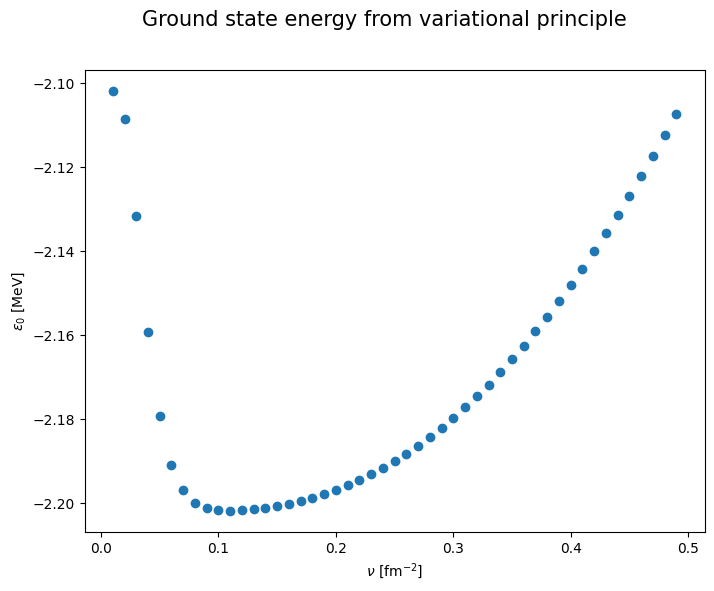

In [12]:
# Plot dell'energia dello stato fondamentale al variare di nu

fig, x = plt.subplots(1, figsize=(8, 6))

fig.suptitle('Ground state energy from variational principle', fontsize=15)

x.scatter(nu[:O-1], ground_state[:O-1])

xlabel (r'$\nu$ [fm$^{-2}$]')
ylabel (r'$\varepsilon_{0}$ [MeV]')

plt.show()